# EMF RBM Class Test



In [108]:
import numpy as np
import h5py

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import linear_model, datasets, metrics, preprocessing 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [121]:
# %load emf_rbm.py

import time

import numpy as np
import scipy.sparse as sp


from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.externals.six.moves import xrange
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import gen_even_slices
from sklearn.utils import issparse
from sklearn.utils.validation import check_is_fitted

from sklearn.utils.fixes import expit  # logistic function  
from sklearn.utils.extmath import safe_sparse_dot, log_logistic, softmax

class EMF_RBM(BaseEstimator, TransformerMixin):
    """Extended Mean Field Restricted Boltzmann Machine (RBM).
    A Restricted Boltzmann Machine with binary visible units and
    binary hidden units. Parameters are estimated using the Extended Mean
    Field model, based on the TAP equations
    Read more in the :ref:`User Guide <rbm>`.
    Parameters
    ----------
    n_components : int, optional
        Number of binary hidden units.
    learning_rate : float, optional
        The learning rate for weight updates. It is *highly* recommended
        to tune this hyper-parameter. Reasonable values are in the
        10**[0., -3.] range.
    batch_size : int, optional
        Number of examples per minibatch.
    momentum : float, optional
        gradient momentum parameter
    decay : float, optional
        decay for weight update regularizer
    weight_decay: string, optional []'L1', 'L2', None]
        weight update regularizer

    neq_steps: int, optional
        Number of equilibration steps
    n_iter : int, optional
        Number of iterations/sweeps over the training dataset to perform
        during training.
    sigma: float, optional
        variance of initial W weight matrix
    thresh: float, optional
        threshold for values in W weight matrix, vectors
    verbose : int, optional
        The verbosity level. The default, zero, means silent mode.
    random_state : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.
    Attributes
    ----------
    h_bias : array-like, shape (n_components,)
        Biases of the hidden units.
    v_bias : array-like, shape (n_features,)
        Biases of the visible units.
    W : array-like, shape (n_components, n_features)
        Weight matrix, where n_features in the number of
        visible units and n_components is the number of hidden units.
    Examples
    --------
    >>> import numpy as np
    >>> X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
    >>> model = EMF_RBM(n_components=2)
    >>> model.fit(X)
    EmfRBM(batch_size=10, learning_rate=0.1, n_components=2, n_iter=10,
           random_state=None, verbose=0)
    References
    ----------
    [1] Marylou Gabrie´, Eric W. Tramel1 and Florent Krzakala1, 
        Training Restricted Boltzmann Machines via the Thouless-Anderson-Palmer Free Energy
        https://arxiv.org/pdf/1506.02914
    """
    def __init__(self, n_components=256, learning_rate=0.005, batch_size=100, sigma=0.001, neq_steps = 3,
                 n_iter=20, verbose=0, random_state=None, momentum = 0.5, decay = 0.01, weight_decay='L1', thresh=1e-8):
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.verbose = verbose

        self.momentum = momentum
        self.decay = decay
        self.weight_decay = weight_decay

        self.sigma = sigma
        self.neq_steps = neq_steps

        # learning rate / mini_batch
        self.lr = learning_rate

        # threshold for floats
        self.thresh = thresh

        # store in case we want to reset
        self.random_state = random_state
        

        # self.random_state_ = random_state
        # always start with new random state
        self.random_state = check_random_state(random_state)
        
        # h bias
        self.h_bias = np.zeros(self.n_components, )
        self.h_samples_ = np.zeros((self.batch_size, self.n_components))
        # moved to fit
        
        self.W = None
        self.dW_prev = None
        self.W2 = None
        self.v_bias = None
        

    def init_weights(self, X):
        """ If the user specifies the training dataset, it can be useful to                                                                                   
        initialize the visibile biases according to the empirical expected                                                                                
        feature values of the training data.                                                                                                              

        TODO: Generalize this biasing. Currently, the biasing is only written for                                                                         
               the case of binary RBMs.
        """
        # 
        eps = self.thresh

        # Mean across  samples 
        if issparse(X):
            probVis = csr_matrix.mean(X, axis=0)
        else:
            probVis = np.mean(X,axis=0)            

        # safe for CSR / sparse mats ?
        # do we need it if we use softmax ?
        probVis[probVis < eps] = eps            # Some regularization (avoid Inf/NaN)  
        #probVis[probVis < (1.0-eps)] = (1.0-eps)   
        self.v_bias = np.log(probVis / (1.0-probVis)) # Biasing as the log-proportion
        
        # (does not work)
        # self.v_bias = softmax(probVis)
        
        # initialize arrays to 0
        self.W = np.asarray(
            self.random_state.normal(
                0,
                self.sigma,
                (self.n_components, X.shape[1])
            ),
            order='fortran')

        self.dW_prev = np.zeros_like(self.W)
        self.W2 = self.W*self.W
        return 0


    def sample_layer(self, layer):
        """Sample from the conditional distribution P(h|v) or P(v|h)"""
        self.random_state = check_random_state(self.random_state)
        sample = (self.random_state.random_sample(size=layer.shape) < layer) 
        return sample

    def _sample_hiddens(self, v):
        """Sample from the conditional distribution P(h|v).
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer to sample from.
        Returns
        -------
        h : array-like, shape (n_samples, n_components)
            Values of the hidden layer.
        """
        return self.sample_layer(self._mean_hiddens(v))

    def _mean_hiddens(self, v):
        """Computes the conditional probabilities P(h=1|v).
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        h : array-like, shape (n_samples, n_components)
            Corresponding mean field values for the hidden layer.
        """
        p = safe_sparse_dot(v, self.W.T) + self.h_bias
        return expit(p, out=p)

    def _sample_visibles(self, h):
        """Sample from the distribution P(v|h).
        Parameters
        ----------
        h : array-like, shape (n_samples, n_components)
            Values of the hidden layer to sample from.
        Returns
        -------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        """
        return sample_layer(self._mean_visible(h))

    def _mean_visibles(self, h):
        """Computes the conditional probabilities P(v=1|h).
        Parameters
        ----------
        h : array-like, shape (n_samples, n_components)
            Corresponding mean field values for the hidden layer.
        Returns
        -------
         v : array-like, shape (n_samples, n_features)
            Values of the visible layer.     
        """
        #p = np.dot(h, self.W) + self.v_bias
        p = safe_sparse_dot(h, W) + self.v_bias
        return expit(p, out=p)

    def sigma_means(self, x, b, W):
        """helper class for computing Wx+b """
        a = safe_sparse_dot(x, W.T) + b
        return expit(a, out=a)

    def init_batch(self, vis):
        """initialize the batch for EMF only"""
        v_pos = vis
        v_init = v_pos

        h_pos = self._mean_hiddens(v_pos)
        h_init = h_pos

        return v_pos, h_pos, v_init, h_init

    def equilibrate(self, v0, h0, iters=3):
        """Run iters steps of the TAP fixed point equations"""
        mv = v0
        mh = h0
     
        for i in range(iters):
            mv = 0.5 *self.mv_update(mv, mh) + 0.5*mv
            mh = 0.5 *self.mh_update(mv, mh) + 0.5*mh
        return mv, mh

    def mv_update(self, v, h):  
        """update TAP visbile magnetizations, to second order"""
        
        # a = np.dot(h, self.W) + self.v_bias
        a = safe_sparse_dot(h, self.W) + self.v_bias

        h_fluc = h-np.multiply(h,h)
        #a += h_fluc.dot(self.W2)*(0.5-v)
        
        # 0.5-v is elementwise => dense
        if issparse(v):
            v_half = (0.5-v.todense())
        else:
             v_half = (0.5-v)
            
        a += np.multiply(safe_sparse_dot(h_fluc,self.W2), v_half)
        return expit(a, out=a)

    def mh_update(self, v, h):
        """update TAP hidden magnetizations, to second order"""
        a = safe_sparse_dot(v, self.W.T) + self.h_bias
 
        v_fluc = (v-(np.multiply(v,v)))
        #a += (v-v*v).dot((self.W2).T)*(0.5-h)
        
        if issparse(h):
            h_half = (0.5-h.to_dense())
        else:        
            h_half = (0.5-h)
            
        a += np.multiply(safe_sparse_dot(v_fluc,self.W2.T),h_half)

        return expit(a, out=a)


    def weight_gradient(self, v_pos, h_pos ,v_neg, h_neg):
        """compute weight gradient of the TAP Free Energy, to second order"""
        # naive  / mean field
        dW = safe_sparse_dot(v_pos.T, h_pos, dense_output=True).T - np.dot(h_neg.T, v_neg)
        
        # tap2 correction
        #  elementwise multiplies
        h_fluc = (h_neg - np.multiply(h_neg,h_neg)).T
        v_fluc = (v_neg - np.multiply(v_neg,v_neg))
        #  dW_tap2 = h_fluc.dot(v_fluc)*self.W
        dW_tap2 = np.multiply(safe_sparse_dot(h_fluc,v_fluc),self.W)

        dW -= dW_tap2
        return dW

    def score_samples(self, X):
        """Compute the pseudo-likelihood of X.
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).
        Returns
        -------
        pseudo_likelihood : array-like, shape (n_samples,)
            Value of the pseudo-likelihood (proxy for likelihood).
        Notes
        -----
        This method is not deterministic: it computes the TAP Free Energy on X,
        then on a randomly corrupted version of X, and
        returns the log of the logistic function of the difference.
        """
        check_is_fitted(self, "W")

        v = check_array(X, accept_sparse='csr')
        v, v_ = self._corrupt_data(v)       

        fe = self._free_energy(v)
        fe_ = self._free_energy(v_)
        return v.shape[1] * log_logistic(fe_ - fe)
    
    
    def score_samples_TAP(self, X):
        """Compute the pseudo-likelihood of X using second order TAP
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).
        Returns
        -------
        pseudo_likelihood : array-like, shape (n_samples,)
            Value of the pseudo-likelihood (proxy for likelihood).
        Notes
        -----
        This method is not deterministic: it computes the TAP Free Energy on X,
        then on a randomly corrupted version of X, and
        returns the log of the logistic function of the difference.
        """
        check_is_fitted(self, "W")

        v = check_array(X, accept_sparse='csr')      
        v, v_ = self._corrupt_data(v)       

        fe = self._free_energy_TAP(v)
        fe_ = self._free_energy_TAP(v_)
        return v.shape[1] * log_logistic(fe_ - fe)
    
    def _corrupt_data(self, v):
        self.random_state = check_random_state(self.random_state)
        """Randomly corrupt one feature in each sample in v."""
        ind = (np.arange(v.shape[0]),
               self.random_state.randint(0, v.shape[1], v.shape[0]))
        if issparse(v):
            data = -2 * v[ind] + 1
            v_ = v + sp.csr_matrix((data.A.ravel(), ind), shape=v.shape)
        else:
            v_ = v.copy()
            v_[ind] = 1 - v_[ind]
        return v, v_
    
    
    def score_samples_entropy(self, X):
        """Compute the entropy of X
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).
        Returns
        -------
        entropy : array-like, shape (n_samples,)
            Value of the entropy.
        Notes
        -----
        This method is not deterministic: it computes the entropy on X,
        then on a randomly corrupted version of X, and returns the difference.
        """
        check_is_fitted(self, "W")

        v = check_array(X, accept_sparse='csr')
        v, v_ = self._corrupt_data(v)       

        s = self._entropy(v)
        s_ = self._entropy(v_)
        return v.shape[1] * (s_ - s)

    
        #TODO: run per column
    def _denoise(self, m, eps=1.0e-8):
        """denoise magnetization"""
        m = np.maximum(m,eps)
        m = np.minimum(m,1.0-eps)
        return m


    def _free_energy_TAP(self, v):
        """Computes the TAP Free Energy F(v) to second order
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        free_energy : array-like, shape (n_samples,)
            The value of the free energy.
        """
        #fe = (- safe_sparse_dot(v, self.v_bias)
        #        - np.logaddexp(0, safe_sparse_dot(v, self.W.T)
        #                       + self.h_bias).sum(axis=1))
        
        h = self._mean_hiddens(v)
        mv, mh = self.equilibrate(v, h, iters=self.neq_steps)
        
        print "mv, mh", np.linalg.norm(mv,ord=2), np.linalg.norm(mh,ord=2)

        
        mv = self._denoise(mv)
        mh = self._denoise(mh)
        
        print "denoised mv, mh", np.linalg.norm(mv,ord=2), np.linalg.norm(mh,ord=2)

        # sum over nodes: axis=1
        
        U_naive = (-safe_sparse_dot(mv, self.v_bias) 
                    -safe_sparse_dot(mh, self.h_bias) 
                        -(mv.dot(self.W.T)*(mh)).sum(axis=1))     

        Entropy = ( -(mv*np.log(mv)+(1.0-mv)*np.log(1.0-mv)).sum(axis=1)  
                    -(mh*np.log(mh)+(1.0-mh)*np.log(1.0-mh)).sum(axis=1) )
                   
        h_fluc = (mh - (mh*mh))
        v_fluc = (mv - (mv*mv))

        # if we do it this way, we need to normalize by 1/batch_size 
        # which we need to obtain from the W2 matrix
        # (I think because of the double sum)
        # this is not obvious in the paper...have to be very careful here
        tap_norm = 1.0/float(mv.shape[0])
        dW_tap2 = h_fluc.dot(self.W2).dot(v_fluc.T)

        # julia way, does not require extra norm, but maybe slower ?
        # dW_tap2 = h_fluc.dot(self.W2)*v_fluc
        Onsager = (-0.5*dW_tap2).sum(axis=1)*tap_norm
        fe_tap = U_naive + Onsager - Entropy
        
        print "S ", np.mean(Entropy)
        print "U ", np.mean(U_naive)
        print "O ", np.mean(Onsager)

        return fe_tap 


    
    def _free_energy(self, v):
        """Computes the RBM Free Energy F(v) 
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        free_energy : array-like, shape (n_samples,)
            The value of the free energy.
        """
        fe = (- safe_sparse_dot(v, self.v_bias)
                - np.logaddexp(0, safe_sparse_dot(v, self.W.T)
                               + self.h_bias).sum(axis=1) )

        return fe 
    
    
    def _entropy(self, v):
        """Computes the TAP Free Energy F(v) to second order
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        entropy : array-like, shape (n_samples,)
            The value of the entropy.
        """
         
        h = self._mean_hiddens(v)
        mv, mh = self.equilibrate(v, h, iters=self.neq_steps)

        mv = self._denoise(mv)
        mh = self._denoise(mh)

        # appears to be wrong ?  unsure why ?  maybe because it is not denoised !!!
        Entropy = ( -(mv*np.log(mv)+(1.0-mv)*np.log(1.0-mv)).sum(axis=1)  
                    -(mh*np.log(mh)+(1.0-mh)*np.log(1.0-mh)).sum(axis=1)  )
                         
        return Entropy


    
    def _free_energy(self, v):
        """Computes the RBM Free Energy F(v) 
        Parameters
        ----------
        v : array-like, shape (n_samples, n_features)
            Values of the visible layer.
        Returns
        -------
        free_energy : array-like, shape (n_samples,)
            The value of the free energy.
        """
        fe = (- safe_sparse_dot(v, self.v_bias)
                - np.logaddexp(0, safe_sparse_dot(v, self.W.T)
                               + self.h_bias).sum(axis=1) )

        return fe 

    
    def partial_fit(self, X, y=None):
        """Fit the model to the data X which should contain a partial
        segment of the data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        Returns
        -------
        self : EMF_RBM
            The fitted model.
        """
        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        if not hasattr(self, 'random_state_'):
            self.random_state_ = check_random_state(self.random_state)
        if not hasattr(self, 'W'):
            self.W = np.asarray(
                self.random_state_.normal(
                    0,
                    0.01,
                    (self.n_components, X.shape[1])
                ),
                order='F')
        if not hasattr(self, 'h_bias'):
            self.h_bias = np.zeros(self.n_components, )
        if not hasattr(self, 'v_bias'):
            self.v_bias = np.zeros(X.shape[1], )

        # not used ?
        #if not hasattr(self, 'h_samples_'):
        #    self.h_samples_ = np.zeros((self.batch_size, self.n_components))

        self._fit(X)

    def _fit(self, v_pos):
        """Inner fit for one mini-batch.
        Adjust the parameters to maximize the likelihood of v using
        Extended Mean Field theory (second order TAP equations).
        Parameters
        ----------
        v_pos : array-like, shape (n_samples, n_features)
            The data to use for training.
        """
        X_batch = v_pos
        lr = float(self.learning_rate) / X_batch.shape[0]
        decay = self.decay

        v_pos, h_pos, v_init, h_init = self.init_batch(X_batch)
              
        a = safe_sparse_dot(h_init, self.W, dense_output=True) + self.v_bias
        a = expit(a, out=a)

        # get_negative_samples
        v_neg, h_neg = self.equilibrate(v_init, h_init, iters=self.neq_steps) 
        
        # basic gradient
        dW = self.weight_gradient(v_pos, h_pos ,v_neg, h_neg) 

        # regularization based on weight decay
        #  similar to momentum >
        if self.weight_decay == "L1":
            dW -= decay * np.sign(self.W)
        elif self.weight_decay == "L2":
            dW -= decay * self.W

        # can we use BLAS here ?
        # momentum
        # note:  what do we do if lr changes per step ? not ready yet
        dW += self.momentum * self.dW_prev  
        # update
        self.W += lr * dW 

        # storage for next iteration

        # is this is a memory killer 
        self.dW_prev =  dW  
        
        # is this wasteful...can we avoid storing 2X the W mat ?
        # elementwise multiply
        self.W2 = np.multiply(self.W,self.W)

        # update bias terms
        #   csr matrix sum is screwy, returns [[1,self.n_components]] 2-d array  
        #   so I always use np.asarray(X.sum(axis=0)).squeeze()
        #   although (I think) this could be optimized
        self.v_bias += lr * (np.asarray(v_pos.sum(axis=0)).squeeze() - np.asarray(v_neg.sum(axis=0)).squeeze())
        self.h_bias += lr * (np.asarray(h_pos.sum(axis=0)).squeeze() - np.asarray(h_neg.sum(axis=0)).squeeze())

        return 0

    
    def fit(self, X, y=None):
        """Fit the model to the data X.
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            Training data.
        Returns
        -------
        self : EMF_RBM
            The fitted model.
        """
        verbose = self.verbose
        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        self.random_state = check_random_state(self.random_state)
        
        self.init_weights(X)
        
        n_samples = X.shape[0]
        n_batches = int(np.ceil(float(n_samples) / self.batch_size))
        

        batch_slices = list(gen_even_slices(n_batches * self.batch_size,
                                            n_batches, n_samples))
        
        begin = time.time()
        for iteration in xrange(1, self.n_iter + 1):
            for batch_slice in batch_slices:
                self._fit(X[batch_slice])

            if verbose:
                end = time.time()
                print("[%s] Iteration %d, pseudo-likelihood = %.2f,"
                      " time = %.2fs"
                      % (type(self).__name__, iteration,
                         self.score_samples(X).mean(), end - begin))
                begin = end

        return self
    
    def transform(self, X):
        """Compute the hidden layer activation probabilities, P(h=1|v=X).
        Parameters
        ----------
        X : {array-like, sparse matrix} shape (n_samples, n_features)
            The data to be transformed.
        Returns
        -------
        h : array, shape (n_samples, n_components)
            Latent representations of the data.
        """
        check_is_fitted(self, "W")

        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        return self._mean_hiddens(X)
    
    

# EMF Tests

Designed to match results of julia code

## Test EMF class init

Xdigits


In [65]:
from sklearn.datasets import load_digits
from sklearn.utils.validation import assert_all_finite
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix
from sklearn.utils.testing import (assert_almost_equal, assert_array_equal,
                                   assert_true)


from sklearn.preprocessing import Binarizer
np.seterr(all='warn')

Xdigits = load_digits().data
Xdigits -= Xdigits.min()
Xdigits /= Xdigits.max()

b = Binarizer(threshold=0.001, copy=True)
Xdigits = b.fit_transform(Xdigits)
print Xdigits.shape

(1797, 64)


### create dataset for julia

### julia  xdigits_ex.jl   results checked

### test init

In [66]:
def test_init():
    X = Xdigits.copy()
    assert_almost_equal(np.linalg.norm(X,ord=2), 211.4983270228649  , decimal=12)

    rbm = EMF_RBM(momentum=0.5, n_components=64, batch_size=50 , decay=0.01, learning_rate=0.005, n_iter=0, sigma=0.001, neq_steps=3, verbose=True)
    rbm.fit(X)
    assert_true(np.linalg.norm(rbm.h_bias, ord=2)==0.0)
    assert_true(np.linalg.norm(rbm.lr)==0.005)
    assert_true(np.linalg.norm(rbm.momentum)==0.5)
    assert_true(np.linalg.norm(rbm.decay)==0.01)
    assert_true(np.linalg.norm(rbm.n_iter)==0)
    assert_true(np.linalg.norm(rbm.neq_steps)==3)
    assert_true(np.linalg.norm(rbm.sigma)==0.001)
    assert_true(np.linalg.norm(rbm.verbose)==True)
    assert_true(np.linalg.norm(rbm.n_components)==64)
    assert_true(np.linalg.norm(rbm.thresh)==1e-8)
    assert_true(np.linalg.norm(rbm.batch_size)==50)

    assert_almost_equal(np.linalg.norm(rbm.v_bias,ord=2), 38.97455, decimal=5)

    #assert_true(np.linalg.norm(rbm.weight_decay)=='L1')
    assert_array_equal(X, Xdigits)
    
test_init()

### Test one batch exactly 

#### $\sigma\sim0$, decay = 0 (no regularization)

- note: julia code must also use 1e-8 as eps, not 1e-6

norm of W  0.007628825568441182  
norm W2: 1.8196753262900838e-6

hb 1.004859173557616e-18  
vb 38.97452180357592


pseudo l-hood: -12.962946404073032  
entropy: 68.52758766764042  
TAP free_energy: -24.38378040255592  
U naive: -48.5436547091488  
free energy: -9268.746331749979  
 

In [67]:
def test_one_batch():
    X = Xdigits.copy()
    rbm = EMF_RBM(momentum=0.5, n_components=64, batch_size=100,
                  decay=0.00, learning_rate=0.005, n_iter=0,
                  sigma=1e-16, neq_steps=3, verbose=True, weight_decay=None)
    rbm.init_weights(X);
      
    assert_almost_equal(np.linalg.norm(rbm.W,ord=2), 0.0)
    assert_almost_equal(np.linalg.norm(rbm.W2,ord=2), 0.0 )
    assert_almost_equal(np.linalg.norm(rbm.dW_prev,ord=2),0.0 )
    
    X_batch = X[0:100,:]    
    assert_almost_equal(np.linalg.norm(X_batch,ord=2), 49.31032989212045)

    rbm.partial_fit(X_batch);
    
    assert_almost_equal(np.linalg.norm(rbm.W,ord=2), 0.007628825568441182 )
    
    scored_free_energy = np.average(rbm.score_samples(X_batch))
    avg_free_energy_tap = np.average(rbm._free_energy_TAP(X_batch))
    avg_entropy = np.average(np.average(rbm._entropy(X_batch)))
        
    assert_almost_equal(np.linalg.norm(rbm.v_bias,ord=2), 38.9745218036)
    assert_almost_equal(np.linalg.norm(rbm.h_bias,ord=2),0.0 )    
    assert_almost_equal(np.linalg.norm(rbm.dW_prev,ord=2), 152.57651136882203)
    assert_almost_equal(np.linalg.norm(rbm.W2,ord=2), 0.000001819675326290)

    assert_almost_equal(avg_entropy, 68.52758766764042)
    assert_almost_equal(avg_free_energy_tap, -24.383780402555928)

    return rbm

rbm = test_one_batch()



AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: -117.07124372005572
 DESIRED: -24.383780402555928

### Test 2 batches exactly

In [68]:
def test_two_batches():
    X = Xdigits.copy()
    rbm = EMF_RBM(momentum=0.5, n_components=64, batch_size=100,
                  decay=0.00, learning_rate=0.005, n_iter=0,
                  sigma=1e-16, neq_steps=3, verbose=True, weight_decay=None)
    rbm.init_weights(X);
    X_batch = X[0:100,:]     
    rbm.partial_fit(X_batch);
    X_batch = X[100:200,:]  
    rbm.partial_fit(X_batch);

    assert_almost_equal(np.linalg.norm(rbm.W,ord=2), 0.015478158879359825 )
    
    scored_free_energy = np.average(rbm.score_samples(X_batch))
    avg_free_energy_tap = np.average(rbm._free_energy_TAP(X_batch))
    avg_entropy = np.average(np.average(rbm._entropy(X_batch)))
        
    assert_almost_equal(np.linalg.norm(rbm.v_bias,ord=2), 38.974504602139554)
    assert_almost_equal(np.linalg.norm(rbm.h_bias,ord=2),1.0779652694386856e-6)    
    assert_almost_equal(np.linalg.norm(rbm.dW_prev,ord=2), 178.06423558738115)
    assert_almost_equal(np.linalg.norm(rbm.W2,ord=2), 8.120675004806954e-6)
    #assert_almost_equal(avg_entropy, )
    #assert_almost_equal(avg_free_energy_tap, )

    return rbm

rbm = test_two_batches()

### Test one epoch, $\sigma=0.001$

compare:

5 julia runs  
batch norm of W, hb, vb  0.015177951725370209 6.125160958113443e-5 38.974531344645186  
batch norm of W, hb, vb  0.016005072745766846 6.132506125735679e-5 38.974534343561935  
batch norm of W, hb, vb  0.015518275427920199 6.143705375221393e-5 38.97453267232916
batch norm of W, hb, vb  0.016618832753491925 6.14604623830071e-5 38.97453303623846
batch norm of W, hb, vb  0.015643733669880935 6.131198883353152e-5 38.97453109464897

10 BernoulliRBM runs

In [69]:
def test_one_epoch():
    X = Xdigits.copy()
    rbm = EMF_RBM(momentum=0.5, n_components=64, batch_size=100,
                  decay=0.01, learning_rate=0.005, n_iter=1, 
                  sigma=0.001, neq_steps=3, verbose=False)
    rbm.fit(X);
    
    assert_almost_equal(np.linalg.norm(rbm.v_bias,ord=2),38.974531, decimal=4)
    # really between 0.015 and 0.0165: hard to test properly with a single statement

    assert_almost_equal(np.linalg.norm(rbm.W,ord=2),0.0165, decimal=2)
    assert_almost_equal(np.linalg.norm(rbm.h_bias,ord=2),0.000061, decimal=2)
    
    # non tap FE totally wrong
    # FE ~ -2x.x

    scored_free_energy = np.average(rbm.score_samples(X))
    
    avg_free_energy_tap = np.average(rbm._free_energy_TAP(X))
    avg_entropy = np.average(np.average(rbm._entropy(X)))
    
    #assert_almost_equal(scored_free_energy, -24, decimal=0)  
    #assert_almost_equal(avg_free_energy_tap, -25, decimal=0)  
    assert_almost_equal(avg_entropy, 68.8, decimal=0)
    return rbm

for i in range(1):
    test_one_epoch()

### test partial fit  (1 iter, 1 batch)

<font color='red'>It might be better to remove the regularization to test this</font>

running this 2x works ... unsure why ?

In [72]:
def test_partial_fit():
    X = Xdigits.copy()
    rbm = EMF_RBM(momentum=0.5, n_components=64, batch_size=100,
                  decay=0.01, learning_rate=0.005, n_iter=0, 
                  sigma=0.000000001, neq_steps=3, verbose=True)
    rbm.init_weights(X);
    assert_almost_equal(np.linalg.norm(rbm.v_bias,ord=2), 38.9745518)
    assert_almost_equal(np.linalg.norm(rbm.W,ord=2), 0.000000001)
    assert_almost_equal(np.linalg.norm(rbm.W2,ord=2), 0.000000001)
    assert_almost_equal(np.linalg.norm(rbm.dW_prev,ord=2), 0.000000001)
    assert_almost_equal(np.linalg.norm(rbm.h_bias,ord=2), 0.000000001)

    X_batch = Xdigits.copy()[0:100]
    assert_almost_equal(np.linalg.norm(X_batch,ord=2), 49.3103298921)
    rbm.partial_fit(X_batch)
    assert_almost_equal(np.linalg.norm(rbm.W,ord=2),0.007629, decimal=4)
    assert_almost_equal(np.linalg.norm(rbm.v_bias,ord=2),38.974521, decimal=4)
    assert_almost_equal(np.linalg.norm(rbm.h_bias,ord=2),0.0, decimal=3)    
    
    #there are large variations in dw_prev
    assert_almost_equal(np.linalg.norm(rbm.dW_prev,ord=2),152.6, decimal=1)

# test stochastically (sometimes will fail due to roundoff error in dw_prev)
for i in range(100):
    test_partial_fit()

### Test 2 iterations of the partial fit

In [73]:
def test_partial_fit_2iters():
    X = Xdigits.copy()
    rbm = EMF_RBM(momentum=0.5, n_components=64, batch_size=100,
                  decay=0.01, learning_rate=0.005, n_iter=0, 
                  sigma=0.00000001, neq_steps=3, verbose=True)
    rbm.init_weights(X);
    X_batch = Xdigits.copy()[0:100]
    assert_almost_equal(np.linalg.norm(X_batch,ord=2), 49.3103298921)
    rbm.partial_fit(X_batch)
    
    X_batch = Xdigits.copy()[100:200]
    assert_almost_equal(np.linalg.norm(X_batch,ord=2), 48.96867960939811)
    rbm.partial_fit(X_batch)
    assert_almost_equal(np.linalg.norm(rbm.v_bias,ord=2),38.974504602)
    assert_almost_equal(np.linalg.norm(rbm.h_bias,ord=2),0.000001, decimal=6)
    
    assert_almost_equal(np.linalg.norm(rbm.W,ord=2),0.0154, decimal=3)
    # not correct ?
    assert_almost_equal(np.linalg.norm(rbm.dW_prev,ord=2),177.75, decimal=1)
   

# test stochastically
for i in range(100):
    test_partial_fit_2iters()

In [74]:
def test_fit_xdigits():
    X = Xdigits.copy()
    rbm = EMF_RBM(momentum=0.5, n_components=64, batch_size=100,
                  decay=0.01, learning_rate=0.005, n_iter=20, 
                  sigma=0.001, neq_steps=3, verbose=False)
    rbm.fit(X);
    
    
    
    assert_almost_equal(np.linalg.norm(rbm.W,ord=2),0.02, decimal=1)
    assert_almost_equal(np.linalg.norm(rbm.v_bias,ord=2),38.9747, decimal=3)
    # why is h so different ?
    assert_almost_equal(np.linalg.norm(rbm.h_bias,ord=2),0.0012, decimal=2)
    return rbm
    
rbm = test_fit_xdigits()

### test sample hiddens

IDK why there is a divide-by-zero error

Perhaps the exitp() needs some regularization ?

In [75]:
def test_sample_hiddens():
    rng = np.random.RandomState(0)
    X = Xdigits[:100]
    rbm1 = EMF_RBM(n_components=2, batch_size=5,
                        n_iter=5, random_state=42)
    rbm1.fit(X)

    h = rbm1._mean_hiddens(X[0])
    hs = np.mean([rbm1._sample_hiddens(X[0]) for i in range(100)], 0)

    assert_almost_equal(h, hs, decimal=1)

test_sample_hiddens()  

/Users/charlesmartin14/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:143: RuntimeWarning: divide by zero encountered in divide


### <font color='red'>why divide by zero error ? <font>

### Test Verbose

In [76]:
from sklearn.externals.six.moves import cStringIO as StringIO
def test_rbm_verbose():
    rbm = EMF_RBM(n_iter=2, verbose=10)
    old_stdout = sys.stdout
    sys.stdout = StringIO()
    try:
        rbm.fit(Xdigits)
    finally:
        sys.stdout = old_stdout
        
test_rbm_verbose()   

### Test Transform

In [77]:
def test_transform():
    X = Xdigits[:110] # using 100 causes divide by zero error in mean_hiddens()!
    rbm1 = EMF_RBM(n_components=16, batch_size=5,
                        n_iter=5, random_state=42)
    rbm1.fit(X)

    Xt1 = rbm1.transform(X)
    Xt2 = rbm1._mean_hiddens(X)

    assert_array_equal(Xt1, Xt2)
    
test_transform()

### Test means_hidden

should compare to older RBM

In [78]:
from sklearn.neural_network import BernoulliRBM
rng = np.random.RandomState(42)
X = np.array([[0.], [1.]])
rbm = BernoulliRBM(n_components=2, batch_size=2,
                    n_iter=42, random_state=rng)
# you need that much iters
rbm.fit(X)
#assert_almost_equal(rbm1.W, np.array([[0.02649814], [0.02009084]]), decimal=4)
#assert_almost_equal(rbm1.gibbs(X), X)
print rbm.components_
print rbm.intercept_hidden_
print rbm.intercept_visible_

[[ 0.02649814]
 [ 0.02009084]]
[-0.00342014 -0.00348868]
[ 0.05]


### <font color='red'>Need to work this out by hand </font>



In [79]:
def test_mean_hiddens():
    # Im not entirely sure why this happens, but the hidden units all go to 1/2
    # and the h array is (2,2)
    # need to do by hand
    rng = np.random.RandomState(42)
    X = np.array([[0.], [1.]])
    rbm = EMF_RBM(n_components=2, batch_size=2,
                        n_iter=42, random_state=rng, 
                        decay = 0.0, weight_decay=None, momentum=0)
    rbm.fit(X)
    h = rbm._mean_hiddens(X)
    assert_true(h.shape==(2,2))
    assert_almost_equal(np.linalg.norm(h,ord=2), 1.0, decimal=4)
    assert_almost_equal(h[0,0], 0.5, decimal=3)
    assert_almost_equal(h[0,1], 0.5, decimal=3)
    assert_almost_equal(h[1,0], 0.5, decimal=3)
    assert_almost_equal(h[1,1], 0.5, decimal=3)

    print h
    print rbm.W
    print rbm.v_bias
    
test_mean_hiddens()

[[ 0.5         0.5       ]
 [ 0.50012314  0.49996445]]
[[ 0.00049258]
 [-0.0001422 ]]
[ -7.96246297e-06]


### Test equlibrate

???

In [80]:
def test_fit_equilibrate():
    # Equlibrate on the RBM hidden layer should be able to recreate [[0], [1]]
    # from the same input
    rng = np.random.RandomState(42)
    X = np.array([[0.], [1.]])
    rbm1 = EMF_RBM(n_components=2, batch_size=2,
                        n_iter=42, random_state=rng)
    # you need that much iters
    rbm1.fit(X)
    #assert_almost_equal(rbm1.W, np.array([[0.02649814], [0.02009084]]), decimal=4)
    #assert_almost_equal(rbm1.gibbs(X), X)
    return rbm1, X

rbm, X = test_fit_equilibrate()
print rbm.W

[[  5.15573045e-06]
 [ -1.97855285e-05]]


### Test using sparse CSR matrix

### <font color='red'>need to check sparse matrix results </font>

Must confirm that sparse matrix multiplies are not mis-interpeted as matrix dot products

In [81]:
def test_small_sparse():
    # EMF_RBM should work on small sparse matrices.
    X = csr_matrix(Xdigits[:4])
    EMF_RBM().fit(X)       # no exception

test_small_sparse()

/Users/charlesmartin14/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:143: RuntimeWarning: divide by zero encountered in divide


### Test Free Energy 

In [82]:
from matplotlib import pyplot
import matplotlib as mpl
%matplotlib inline  

def show_image(image): 
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()


### Test Free Energy and Entropy Calculations

actual julia output from xdigits_FE.jl

(info statements added into monitor; I should find a way to add to test code )

S [68.92548157440935,68.67917042062827,68.7382937888165,68.6467445638933,68.94092201361534]  
FE <1-5>[-90.41392263605844 -98.57232874119751 -96.67160538171822 -99.72457836849503 -89.84668949506056]  
FE TAP <1-5>[-117.38187025746029 -117.39051762052955 -117.39024519247155 -117.39408456128287   -117.37959261213285]


?? m vis, hid 11.117791807149395  8.936583879865992  
?? denoised m vis, hid 11.11779180715007  8.936583879865992  

In [130]:
def test_free_energy():
    X = Xdigits.copy()
    rbm = EMF_RBM(n_iter=1, n_components=64,  decay=0.001, sigma=0.0000000000000001, neq_steps=5)
    rbm.fit(X) 
    
    s = rbm._entropy(X)
    print "entropy ", s[0:5]
        
    fe = rbm._free_energy(X)
    print "free energies, old " , fe[0:5]
    
    fe_tap = rbm._free_energy_TAP(X)
    print "TAP free energies ", fe_tap[0:5]
    
    assert_almost_equal(s[0], 68.92548, decimal=3)
    assert_almost_equal(s[1], 68.679170, decimal=3) # a bit more off
    
    assert_almost_equal(fe[0], -90.4139, decimal=3)
    assert_almost_equal(fe[1], -98.5723, decimal=2) # a bit more off
  
    assert_almost_equal(fe_tap[0], -117.3819, decimal=2)
    assert_almost_equal(fe_tap[1], -117.3905, decimal=2)    
    
    return rbm

rbm = test_free_energy()

entropy  [ 68.92500812  68.67868513  68.73780754  68.64628658  68.94040984]
free energies, old  [-90.41429712 -98.57310481 -96.67241348 -99.72444489 -89.84836316]
mv, mh 210.707428877 169.423346805
denoised mv, mh 210.707428877 169.423346805
S  68.8462458135
U  -48.5352952066
O  -2.95285368833e-06
TAP free energies  [-117.38220661 -117.39085455 -117.39058211 -117.3944207  -117.37993056]


### IDK why the mv norms are different...weird ... will dig into a bit

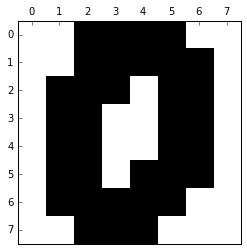

In [137]:
v = X[0,:]
show_image(np.reshape(v,[8,8]))

### TODO:  fix APIs so they can run on 1 vector at a time

In [139]:
rbm._free_energy_TAP(v)

mv, mh 4.9744512468 3.99674446312
denoised mv, mh 4.9744512468 3.99674446312


ValueError: 'axis' entry is out of bounds

In [136]:
vv = np.dot(v,rbm.v_bias) 
ff = (np.logaddexp(0, np.dot(v, rbm.W.T)) + rbm.h_bias).sum(axis=0)
print vv, ff, vv+ff

46.0967018276 44.3172430764 90.413944904


In [ ]:
# correct - implementation is screwy
# fix fix fix